# Nested Sampling test

In [80]:
import sys 
sys.path.insert(1, "..")
import torch
import numpy as np
import gpytorch
import matplotlib.pyplot as plt


In [81]:
def inverse_softplus(x):
    return x + torch.log(-torch.expm1(-x))




def my_softplus(x):
    return torch.log(-1 + torch.exp(x))

torch.nn.functional.softplus(my_softplus(torch.tensor(1)))


def reparameterize_model(model, theta):
    for model_param, sampled_param in zip(model.parameters(), theta):
        model_param.data = torch.full_like(model_param.data, float(sampled_param))

def reparameterize_and_mll(model, likelihood, theta, train_x, train_y):
    reparameterize_model(model, theta)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    mll_val = mll(model(train_x), train_y)
    return mll_val

def log_prior(mean, cov, params):
    # hack for constant noise
    prior = torch.distributions.MultivariateNormal(torch.tensor(mean), torch.tensor(cov))
    log_prob = prior.log_prob(torch.tensor(params[1]))
    return log_prob.squeeze(0)



In [82]:
train_x = torch.linspace(1, 2, 2)
train_y = torch.sin(train_x)
print(train_x)
print(train_y)

tensor([1., 2.])
tensor([0.8415, 0.9093])


In [83]:
inverse_softplus(torch.tensor(0.1))

tensor(-2.2522)

In [84]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
model = ExactGPModel(train_x, train_y, likelihood)

In [85]:
#log_prior(prior_theta_mean, prior_theta_cov, [inverse_softplus(torch.tensor(0.01)), inverse_softplus(torch.tensor(1.))])
#torch.distributions.Normal(torch.tensor(-0.2122), torch.tensor(1.8895426067756804)).log_prob(torch.tensor(inverse_softplus(torch.tensor(1.))))
#torch.distributions.Normal(torch.tensor(0), torch.tensor(1.)).log_prob(torch.tensor(torch.tensor(5.)))

In [86]:
reparameterize_model(model, [inverse_softplus(torch.tensor(0.01)), torch.tensor(1.)])
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll(model(train_x), train_y)*2

tensor(-1.8899, grad_fn=<MulBackward0>)

In [87]:
model.covar_module.lengthscale

tensor([[1.3133]], grad_fn=<SoftplusBackward0>)

In [88]:
"""
There's a bug, what to test?
- Is the covariance matrix the same? (yes, except diagonal)
- Is the MLL the same?
- Is the posterior the same?
- Is the GP really parameterized the same?
- 
"""

"\nThere's a bug, what to test?\n- Is the covariance matrix the same? (yes, except diagonal)\n- Is the MLL the same?\n- Is the posterior the same?\n- Is the GP really parameterized the same?\n- \n"

In [89]:
ell = torch.tensor(2.0)
reparameterize_model(model, [inverse_softplus(torch.tensor(0.01)), ell])
#reparameterize_model(model, [-100, inverse_softplus(torch.tensor(5.))])
print(list(model.parameters()))
print(model.likelihood.noise)
print(model.covar_module.lengthscale)
log_prior_val = torch.distributions.Normal(torch.tensor(0), torch.tensor(1.)).log_prob(ell)
log_like = mll(model(train_x), train_y)*len(train_x)
log_like + log_prior_val

[Parameter containing:
tensor([-4.6002], requires_grad=True), Parameter containing:
tensor([[2.]], requires_grad=True)]
tensor([0.0100], grad_fn=<AddBackward0>)
tensor([[2.1269]], grad_fn=<SoftplusBackward0>)


tensor(-4.4084, grad_fn=<AddBackward0>)

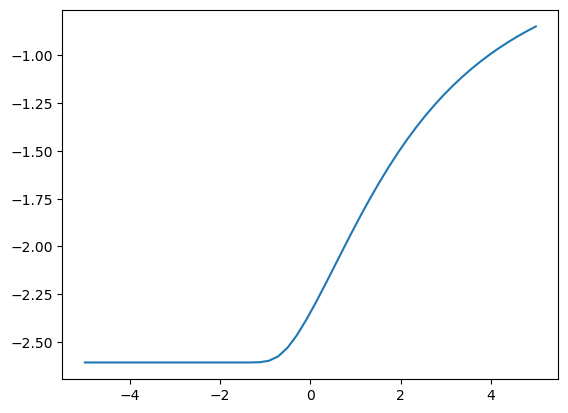

In [90]:
plot_range = torch.linspace(-5, 5, 50)
plt.plot(plot_range, [len(train_x)*reparameterize_and_mll(model, likelihood, [inverse_softplus(torch.tensor(0.01)), ell], train_x, train_y).detach().numpy() for ell in plot_range])


In [91]:
def log_posterior(model, theta):
    try:
        reparameterize_model(model, theta)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        mll(model(train_x), train_y)*len(train_x)
        log_prior_val = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0., 0.]), torch.tensor([[1., 0.], [0., 1.]])).log_prob(theta)
        log_like = mll(model(train_x), train_y)*len(train_x)
    except Exception as E:
        print(theta)
        print(E)

    return (log_like + log_prior_val).detach()

In [92]:
import numpy as np
import dynesty
from dynesty import plotting as dyplot
import scipy
from metrics import prior_distribution




def reparameterize_model(model, theta):
    for model_param, sampled_param in zip(model.parameters(), theta):
        model_param.data = torch.full_like(model_param.data, float(sampled_param))

def reparameterize_and_mll(model, likelihood, theta, train_x, train_y):
    reparameterize_model(model, theta)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    mll_val = mll(model(train_x), train_y)
    return mll_val


def NestedSampling(model):

    prior_theta_mean, prior_theta_cov = prior_distribution(model)

    # Define the dimensionality of our problem.
    ndim = len(list(model.parameters()))

    def loglike(theta_i):
        return (reparameterize_and_mll(model, model.likelihood, theta_i, model.train_inputs[0], model.train_targets)*len(*model.train_inputs)).detach().numpy()

    # Define our prior via the prior transform.
    def prior_transform(u):
        """Transforms the uniform random variables `u ~ Unif[0., 1.)`
        to the parameters of interest."""

        x = np.array(u)  # copy u

        # Bivariate Normal
        t = scipy.stats.norm.ppf(u)  # convert to standard normal
        Csqrt = np.linalg.cholesky(prior_theta_cov.numpy())  
        x = np.dot(Csqrt, t)  # correlate with appropriate covariance
        mu = prior_theta_mean.flatten().numpy()  # mean
        x += mu  # add mean
        return x

    # Trying out dynamic sampler
    dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim, bound='multi')
    dsampler.run_nested(maxiter=500)
    dsampler.run_nested(dlogz_init=0.01, nlive_init=500, nlive_batch=100)
    res = dsampler.results

    # Sample from our distribution.
    #sampler = dynesty.NestedSampler(loglike,
    #                                prior_transform,
    #                                ndim,
    #                                bound='multi',
    #                                sample='auto',
    #                                nlive=100,
    #                                first_update={"min_eff": 3.0})
    #sampler.run_nested(dlogz=0.01)
    #res = sampler.results

    return res

In [93]:
res = NestedSampling(model)

0it [00:00, ?it/s]

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
1001it [00:01, 559.49it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1439 | eff(%): 69.562 | loglstar:   -inf < -0.566 <    inf | logz: -2.221 +/-  0.045 | dlogz:  0.004 >  0.010]
2628it [00:07, 392.28it/s, batch: 6 | bound: 0 | nc: 3 | ncall: 7582 | eff(%): 34.210 | loglstar: -4.052 < -2.605 < -2.605 | logz: -2.225 +/-  0.035 | stop:  4.692] /home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
3077it [00:09, 422.82it/s, batch: 8 | bound: 0 | nc: 1 | ncall: 8460 | eff(%): 35.942 | loglstar: -3.734 < -2.605 < -2.605 | logz: -2.226 +/-  0.034 | stop:  3.831]/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in c

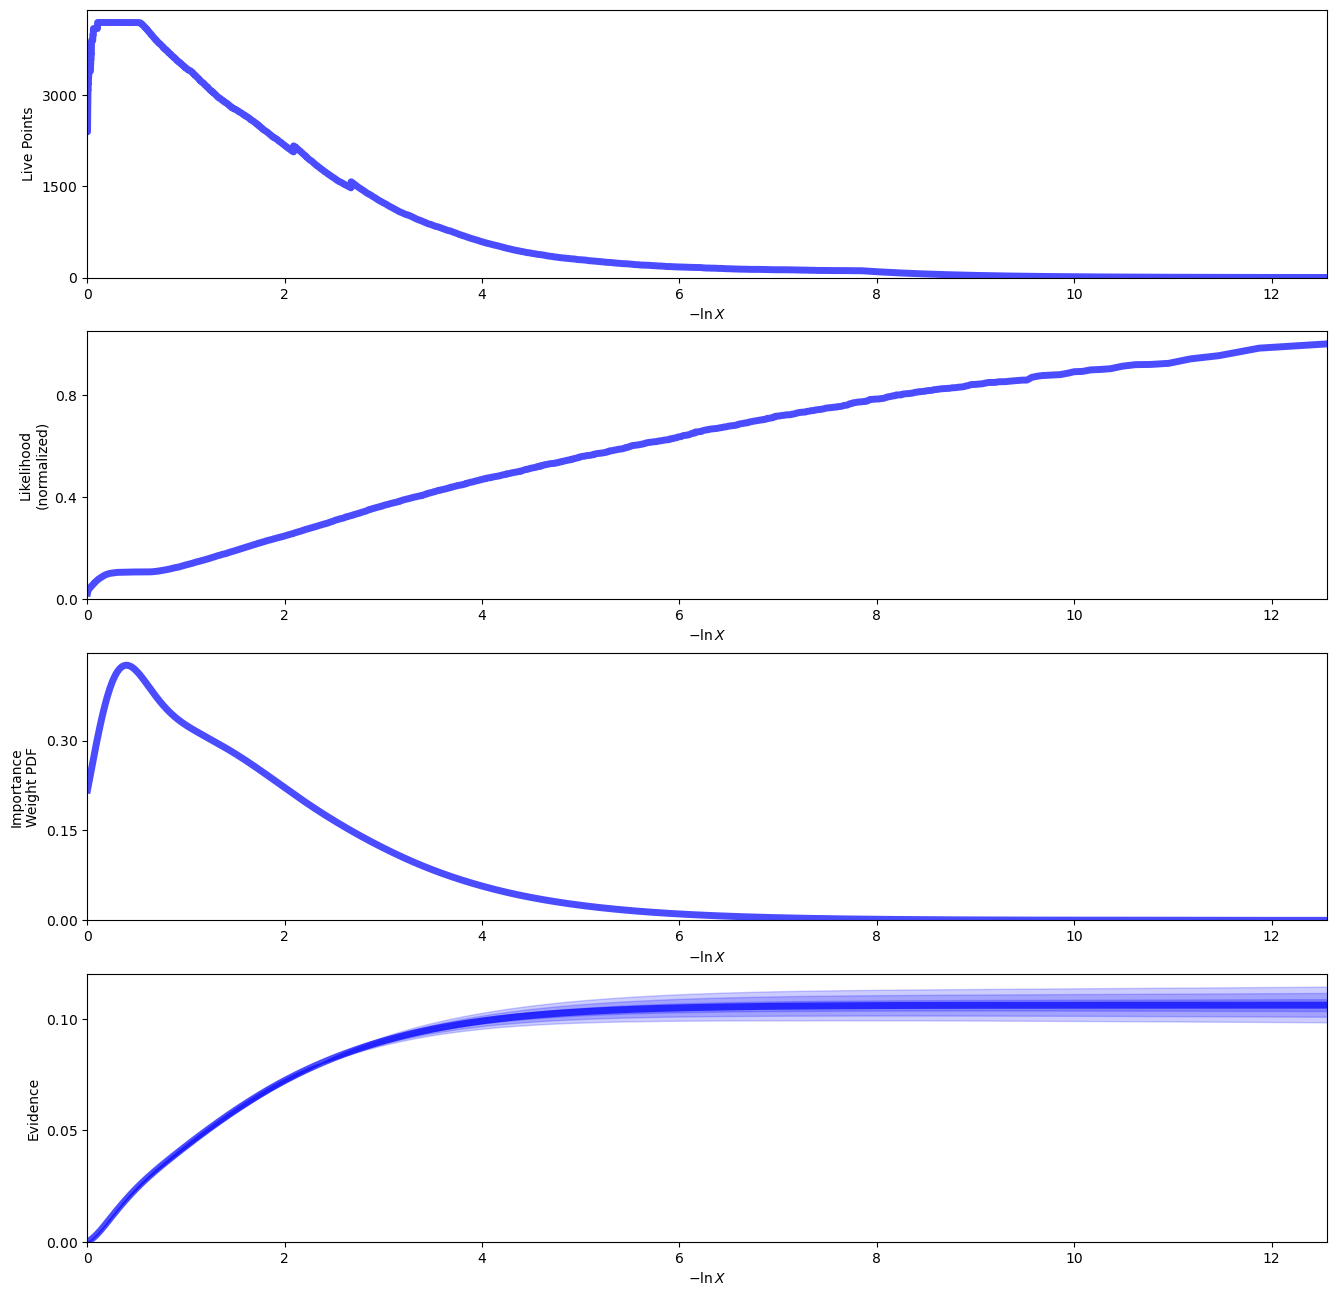

In [94]:
# TODO Bei jedem Call die Bilder erstellen lassen und wegspeichern
fig, axes = dyplot.runplot(res)#, lnz_truth=lnz_truth)

In [98]:
res.summary()

Summary
niter: 10327
ncall: 25292
eff(%): 37.772
logz: -2.243 +/-  0.025


['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'batch_nlive', 'batch_bounds', 'blob', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale']


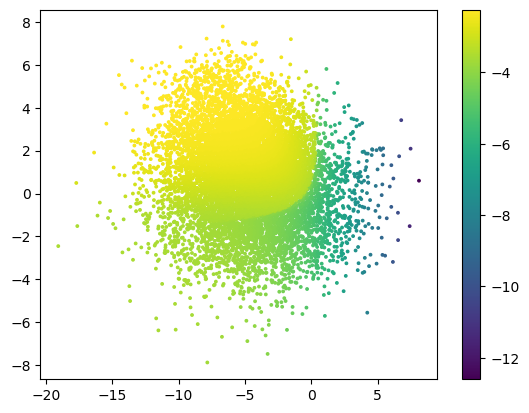

In [105]:
print(res.keys())
# noise/lengthscale
plt.scatter(res.samples[:,0], res.samples[:,1], c=res.logz, s=3)
plt.colorbar()

(array([2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 1.000e+01, 9.000e+00,
        6.000e+00, 2.700e+01, 3.600e+01, 3.600e+01, 5.500e+01, 6.500e+01,
        1.140e+02, 1.160e+02, 1.680e+02, 2.100e+02, 2.130e+02, 2.930e+02,
        3.560e+02, 4.130e+02, 5.080e+02, 5.960e+02, 7.690e+02, 8.630e+02,
        1.025e+03, 1.107e+03, 1.252e+03, 1.493e+03, 1.700e+03, 1.882e+03,
        2.174e+03, 2.244e+03, 2.601e+03, 2.626e+03, 2.877e+03, 2.937e+03,
        3.176e+03, 3.281e+03, 3.537e+03, 3.399e+03, 3.572e+03, 3.633e+03,
        3.651e+03, 3.655e+03, 3.591e+03, 3.594e+03, 3.329e+03, 3.240e+03,
        2.992e+03, 2.818e+03, 2.787e+03, 2.549e+03, 2.349e+03, 2.083e+03,
        1.937e+03, 1.713e+03, 1.483e+03, 1.365e+03, 1.227e+03, 1.019e+03,
        8.900e+02, 7.360e+02, 7.340e+02, 5.480e+02, 4.520e+02, 3.800e+02,
        2.880e+02, 2.360e+02, 2.420e+02, 1.610e+02, 1.380e+02, 9.700e+01,
        7.100e+01, 6.900e+01, 4.500e+0

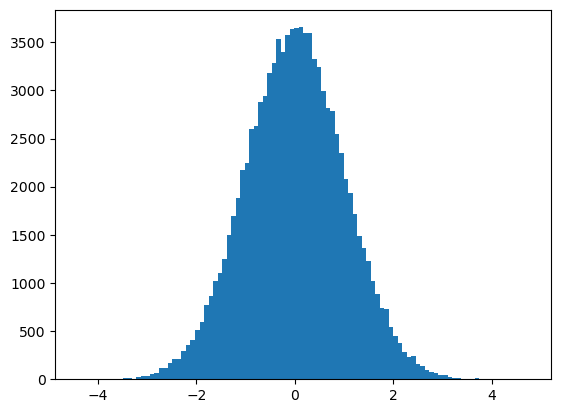

In [97]:

import numpy as np
import dynesty
from dynesty import plotting as dyplot
import scipy
# What does ppf do?
u = torch.distributions.uniform.Uniform(0, 1).sample((100000,))

# Bivariate Normal
t = scipy.stats.norm.ppf(u) 
plt.hist(t,bins=100)